<h1>Collaborative Filtering Movie Recommendation - Item Based</h1>

The user-based collaborative filtering system, information of movies of director, acotors and tags have been preprocessed and stored in "similar_movies_director.csv", "similar_movie_actors.csv" and "similar_movies_tags.csv" separately. Combined similarity between movies will be calculated from these three files. After getting the combined similarity, the generation of the prediction will follow the fomula below:

Given a user u, generate a prediction for an item i by using a weighted sum of the user u’s ratings for items that are most similar to i.


$$
\text{pred}(u, i) =\frac{\sum_{j \in \text{ratedItems}(u)} \text{sim}(i, j) \cdot r_{uj}}{\sum_{j \in \text{ratedItems}(u)} \text{sim}(i, j)}
$$

<h3>import data</h3>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Information about director similarity of movies.
similar_movies_director = pd.read_csv(r'F:\DS_Dataset\final\item-based\similar_movies_director.csv')
similar_movies_director

,movie_id,director,other_movies
0,1,John Lasseter,"[2355, 42191, 45517, 95446, 95628, 95856, 2139..."
1,2,Joe Johnston,"[2054, 2094, 2501, 4638, 7324, 74452, 88140, 1..."
2,3,Howard Deutch,"[460, 1290, 1837, 2145, 3861, 4509, 6841, 7381..."
3,4,Forest Whitaker,"[1888, 8869, 88761]"
4,5,Charles Shyer,"[360, 4080, 4959, 6944, 8948, 26514]"
...,...,...,...
84656,239306,Charles S. Dubin,"[111573, 179605, 180797, 238546]"
84657,239308,William Hale,"[139743, 168190]"
84658,239310,Phontharis Chotkijsadarsopon,"[207654, 239312]"
84659,239312,Phontharis Chotkijsadarsopon,"[207654, 239310]"


For director missing movies, it makes sense to combine these Microcinem into one catagory in terms of director.

In [3]:
# convert similar_movies_director to a dictionary to help optimising algorithm performance.
import ast

def convert_to_int_list(string_list):
    try:
        return [int(item) for item in ast.literal_eval(string_list)]
    except:
        return []

similarity_data_director = pd.Series(
    similar_movies_director.other_movies.apply(convert_to_int_list).values, 
    index=similar_movies_director.movie_id
).to_dict()

In [4]:
# Information about director similarity of tags.
similar_movies_tags = pd.read_csv(r'F:\DS_Dataset\final\item-based\similar_movies_tags.csv')
similar_movies_tags

,item_id,similar_movie,cos_sim
0,1,5218,0.630900
1,1,4886,0.575396
2,1,6377,0.557504
3,1,3114,0.526077
4,1,4306,0.487821
...,...,...,...
1410891,238060,91450,0.353553
1410892,238060,104337,0.353553
1410893,238060,167064,0.353553
1410894,238060,194074,0.353553


In [5]:
# convert similar_movies_tags to a dictionary to help optimising algorithm performance.
similarity_data_tags = {}
for _, row in similar_movies_tags.iterrows():
    item_id = row['item_id']
    similar_movie = row['similar_movie']
    cos_sim = row['cos_sim']

    if item_id not in similarity_data_tags:
        similarity_data_tags[item_id] = {}

    similarity_data_tags[item_id][similar_movie] = cos_sim

In [6]:
# Information about director similarity of actors.
similar_movies_actors = pd.read_csv(r'F:\DS_Dataset\final\item-based\similar_movies_actors.csv')
similar_movies_actors

,movie_id,similar_movie,jac_sim
0,1,3114,0.476190
1,1,78499,0.216216
2,1,106022,0.200000
3,1,8961,0.105263
4,1,73469,0.100000
...,...,...,...
1862134,239250,26416,1.000000
1862135,239250,26448,1.000000
1862136,239250,26553,1.000000
1862137,239250,26602,1.000000


In [7]:
# convert similar_movies_actors to a dictionary to help optimising algorithm performance.
similarity_data_actors = {}
for _, row in similar_movies_actors.iterrows():
    item_id = row['movie_id']
    similar_movie = row['similar_movie']
    jac_sim = row['jac_sim']

    if item_id not in similarity_data_actors:
        similarity_data_actors[item_id] = {}

    similarity_data_actors[item_id][similar_movie] = jac_sim

In [8]:
ratings = pd.read_csv(r'F:\DS_Dataset\final\item-based\ratings.csv')
ratings

,item_id,user_id,rating
0,1,0,3.5
1,1,19,5.0
2,1,24,3.0
3,1,25,3.0
4,1,42,5.0
...,...,...,...
28249186,237107,672530,4.5
28249187,237127,619061,3.0
28249188,237129,594170,4.0
28249189,237131,395134,2.5


<h3>masking ratings to determine weights of the three attributes (example for one user)</h3>

Select user 19 as an example.

In [9]:
user_example = ratings[ratings["user_id"]==19]
user_example

,item_id,user_id,rating
1,1,19,5.0
127498,6,19,3.0
177256,10,19,3.0
245912,16,19,3.0
267080,17,19,3.0
...,...,...,...
9619052,1552,19,3.0
9678395,1573,19,4.0
9746291,1584,19,3.0
9985405,1639,19,5.0


Split user 19's rating into 60% baseline set, 20% optimization set and 20% test set. 

Baseline set: Used for generating similarity scores, serving as the basis for subsequent recommendation calculations.

Optimization set : Used for adjusting the weights or parameters of the model. This dataset is used for fine-tuning the model to optimize the performance of the recommendation system.

Test set: Used for the final evaluation of the model's performance.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Split the baseline, optimization and test set.
baseline_set, temp_set = train_test_split(user_example, test_size=0.4, random_state=42)
optimization_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)
print("Baseline set:\n", baseline_set.shape)
print("\nOptimization set:\n", optimization_set.shape)
print("\nTest set:\n", test_set.shape)

Baseline set:
 (165, 3)

Optimization set:
 (55, 3)

Test set:
 (55, 3)


In [12]:
# Function to calculate the predicted rating for a movie based on other similar movies
def predicted_rating(movie_id, baseline, weights):
    total_similarity = 0
    weighted_ratings_sum = 0

    # iterate each movie in the baseline set
    for _, row in baseline.iterrows():
        baseline_movie_id = row['item_id']
        user_rating = row['rating']
        
        # get the sim_tags
        sim_tags = similarity_data_tags.get(baseline_movie_id, {}).get(movie_id , 0)
        # get the sim_actors
        sim_actors = similarity_data_actors.get(baseline_movie_id, {}).get(movie_id, 0)
        # get the sim_director
        if baseline_movie_id in similarity_data_director.get(movie_id, []):
            sim_director = 1
        else:
            sim_director = 0

        # Linear combination of three simlarities by weights
        sim_combine = (weights[0] * sim_tags + weights[1] * sim_actors + weights[2] * sim_director)

        weighted_ratings_sum += sim_combine * user_rating
        total_similarity += sim_combine

    if total_similarity == 0:
        return 0

    return weighted_ratings_sum / total_similarity

In [13]:
# Objective function to minimize the mean square error of predictted rating on the optimization set.
def objective_function(weights, baseline_set, optimization_set):
    pred_errors = [np.square(optimization_set.iloc[i]['rating'] - 
                             predicted_rating(optimization_set.iloc[i]['item_id'], baseline_set, weights))
                   for i in range(len(optimization_set))]
    return np.mean(pred_errors)

In [14]:
# Initial weights
initial_weights = [1, 1, 1]

In [15]:
from scipy.optimize import minimize

In [16]:
# Optimization using scipy's minimize function.
result = minimize(objective_function, initial_weights, args=(baseline_set, optimization_set), 
                  method='BFGS', options={'disp': True})
optimized_weights = result.x
optimized_weights

Optimization terminated successfully.
         Current function value: 2.036753
         Iterations: 9
         Function evaluations: 96
         Gradient evaluations: 24


array([0.0333777 , 0.67484034, 2.29110479])

For the example user 19, the best weight for tags, actors and director is [0.0333777 , 0.67484034, 2.29110479].

In [17]:
# MSE on the optimization set.
objective_function(optimized_weights, baseline_set, optimization_set)

2.0367525950280734

In [18]:
# MSE on the test set.
objective_function(optimized_weights, baseline_set, test_set)

1.6477586814310479

The mean square error in the test set is relatively low, suggesting that weights [0.0333777 , 0.67484034, 2.29110479] is suitable for user 19.

<h3>masking ratings to determine weights of the three attributes (statistic analysis)</h3>

We will randomly select 500 users and repeat the procedure we did for user 19, recording their optimized weights and the mean square error in the test sets.

In [19]:
import random

In [20]:
# randomly select 500 users
random_seed = 42
random.seed(random_seed)

user_ids = ratings['user_id'].unique()
random_selected_users = random.sample(list(user_ids), 500)

In [21]:
initial_weights = [1, 1, 1] 

min_ratings = 10

results = []

for user_id in random_selected_users:
    # Get ratings for the current user
    user_ratings = ratings[ratings["user_id"] == user_id]

    # Check if the user has at least the minimum number of ratings
    if len(user_ratings) >= min_ratings:
        # Split the data for the current user
        baseline_set, temp_set = train_test_split(user_ratings, test_size=0.4, random_state=42)
        optimization_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

        # Optimize weights using the minimize function
        result = minimize(objective_function, initial_weights, args=(baseline_set, optimization_set), 
                          method='BFGS')
        optimized_weights = result.x

        # Calculate MSE on the test set
        mse_test = objective_function(optimized_weights, baseline_set, test_set)

        results.append([
            user_id, 
            optimized_weights[0],  
            optimized_weights[1],  
            optimized_weights[2],  
            mse_test,              
            len(user_ratings)      
        ])
    else:
        print(f"Skipping user {user_id} due to insufficient data.")

results_df = pd.DataFrame(results, columns=['user_id', 'weight_tag', 'weight_actor', 'weight_director', 'MSE_testset', 'num_ratings'])
results_df

Skipping user 939122 due to insufficient data.
Skipping user 343541 due to insufficient data.
Skipping user 943397 due to insufficient data.
Skipping user 307846 due to insufficient data.
Skipping user 352401 due to insufficient data.
Skipping user 646390 due to insufficient data.
Skipping user 754069 due to insufficient data.
Skipping user 237002 due to insufficient data.
Skipping user 714264 due to insufficient data.
Skipping user 709605 due to insufficient data.
Skipping user 899680 due to insufficient data.
Skipping user 660584 due to insufficient data.
Skipping user 853301 due to insufficient data.
Skipping user 474634 due to insufficient data.
Skipping user 389883 due to insufficient data.
Skipping user 587321 due to insufficient data.
Skipping user 285562 due to insufficient data.
Skipping user 923137 due to insufficient data.
Skipping user 278282 due to insufficient data.
Skipping user 485867 due to insufficient data.
Skipping user 924319 due to insufficient data.
Skipping user

,user_id,weight_tag,weight_actor,weight_director,MSE_testset,num_ratings
0,854937,0.186555,1.803129,1.000000e+00,3.536994,63
1,440422,0.741529,1.030073,1.224605e+00,1.432668,610
2,97794,1.009243,2.110078,-1.212663e-01,1.088749,358
3,756929,1.000000,1.000000,1.000000e+00,0.127238,16
4,603025,0.450318,2.960164,-4.244185e-01,4.011973,107
...,...,...,...,...,...,...
439,270872,0.309085,3.283153,-1.112691e-01,2.369712,47
440,962013,-0.443926,2.443732,1.000000e+00,17.200000,23
441,507374,0.651888,3.018986,-6.708856e-01,8.849889,54
442,886396,1.649499,-0.210209,1.519809e+00,1.071894,599


In [23]:
results_df.to_csv('weights_analysis.csv',index=False)

To establish a foundational framework for our recommendation system, we take into account two key standards:
1. A lower Mean Squared Error (MSE) indicates a higher accuracy in predictions.
2. Users who provide a greater number of ratings are generally considered more reliable.

In [24]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Distribution of MSE in Test Set')

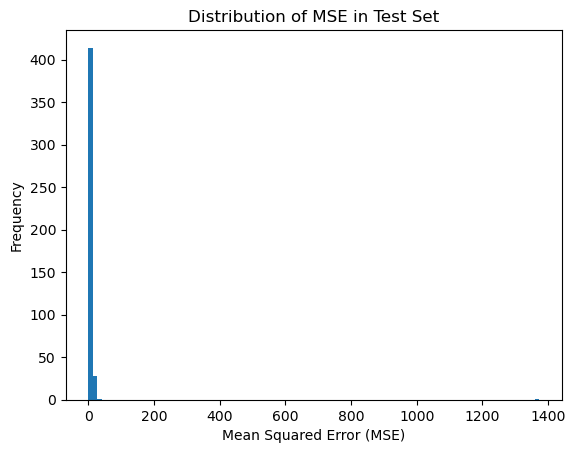

In [25]:
# Distribution of MSE
plt.hist(results_df["MSE_testset"], bins = 100)
plt.xlabel('Mean Squared Error (MSE)')  
plt.ylabel('Frequency')               
plt.title('Distribution of MSE in Test Set')  

The distribution of MSE values in the dataset is highly skewed towards the lower end, indicating that the majority of the data points have a lower Mean Squared Error. 

Text(0.5, 1.0, 'Distribution of num_ratings in Test Set')

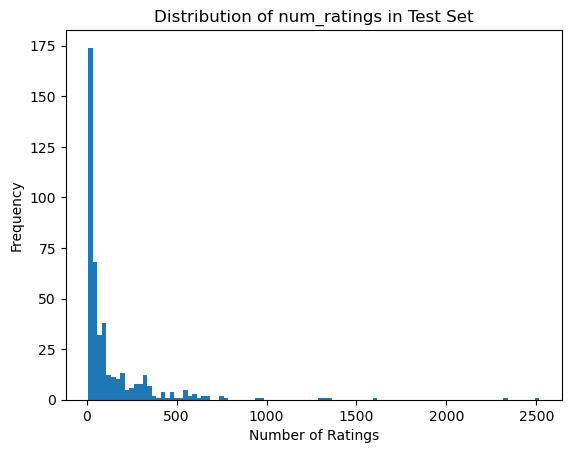

In [26]:
# Distribution of num_ratings
plt.hist(results_df["num_ratings"], bins = 100)
plt.xlabel('Number of Ratings')  
plt.ylabel('Frequency')               
plt.title('Distribution of num_ratings in Test Set')  

The distribution of num_ratings values in the dataset is also skewed towards the lower end, indicating that the majority of the data points have a lower num_ratings.

We will filter out users with enough number of ratings and also with relatively low MSE. For MSE, we will filter out users with number of ratings lower than 75% quantile. For num_ratings, we will filter out users with num_ratings higher than 25% quantile.

In [27]:
# Calculating the percentiles for MSE and num_ratings
mse_75_q = results_df['MSE_testset'].quantile(0.75)
num_ratings_25_q = results_df['num_ratings'].quantile(0.25)

# Filter the data based on these percentiles
filtered_users = results_df[(results_df['MSE_testset'] <= mse_75_q) & 
                             (results_df['num_ratings'] >= num_ratings_25_q)]
filtered_users

,user_id,weight_tag,weight_actor,weight_director,MSE_testset,num_ratings
0,854937,0.186555,1.803129,1.000000e+00,3.536994,63
1,440422,0.741529,1.030073,1.224605e+00,1.432668,610
2,97794,1.009243,2.110078,-1.212663e-01,1.088749,358
4,603025,0.450318,2.960164,-4.244185e-01,4.011973,107
5,964494,1.091777,1.499974,3.927511e-01,1.819399,319
...,...,...,...,...,...,...
437,524093,1.271877,1.829859,-1.060980e-01,0.941394,424
438,293819,0.514190,1.464702,9.942265e-01,2.589329,308
439,270872,0.309085,3.283153,-1.112691e-01,2.369712,47
442,886396,1.649499,-0.210209,1.519809e+00,1.071894,599


We will use these 281 users to determine a foundational framework for our recommendation system.

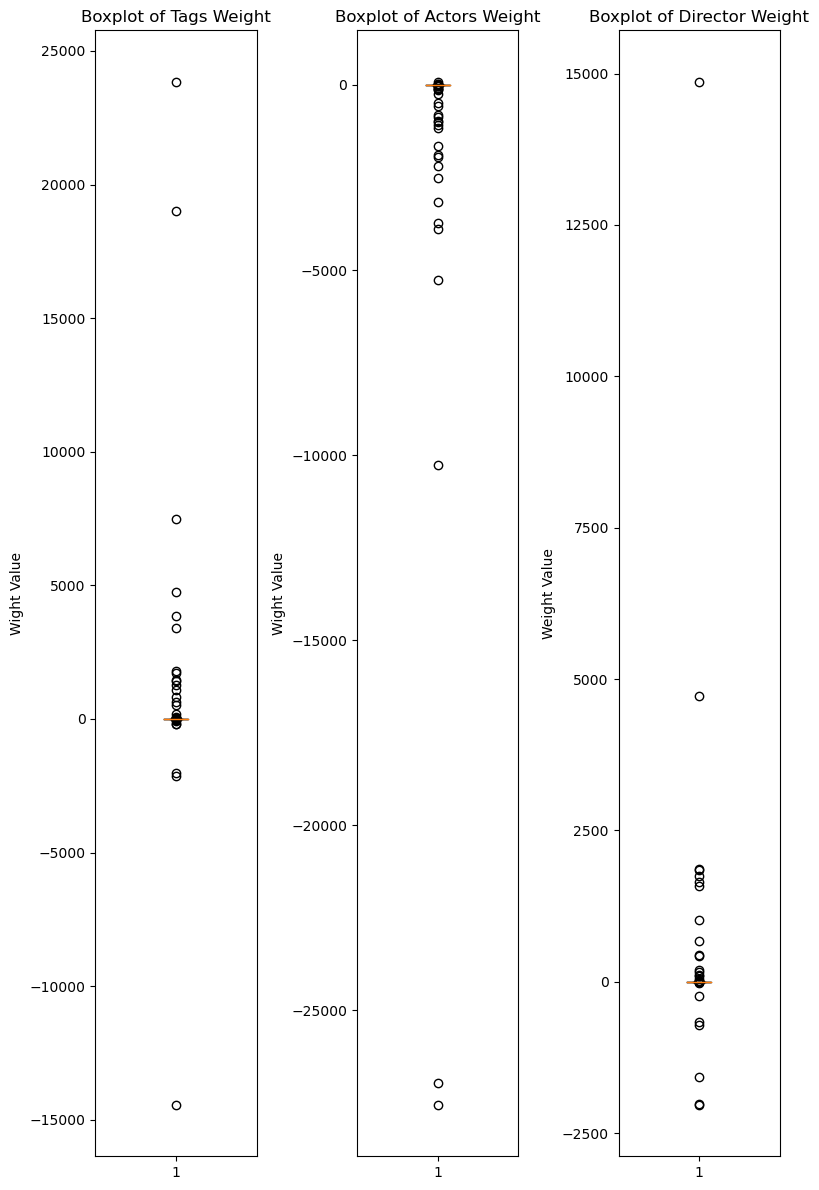

In [28]:
# Creating a figure and 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 12))

# Plotting tags weight
ax1.boxplot(filtered_users['weight_tag'])
ax1.set_title('Boxplot of Tags Weight')
ax1.set_ylabel('Wight Value')

# Plotting actors weight
ax2.boxplot(filtered_users['weight_actor'])
ax2.set_title('Boxplot of Actors Weight')
ax2.set_ylabel('Wight Value')

# Plotting director weight
ax3.boxplot(filtered_users['weight_director'])
ax3.set_title('Boxplot of Director Weight')
ax3.set_ylabel('Weight Value')


plt.tight_layout()
plt.show()

All three weights have some extreme values. We will use IQR method to detect and remove these outliers.

In [29]:
# Calculating IQR for each weight
Q1 = filtered_users[['weight_tag', 'weight_actor', 'weight_director']].quantile(0.25)
Q3 = filtered_users[['weight_tag', 'weight_actor', 'weight_director']].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers specifically for the weight columns
condition = ((filtered_users[['weight_tag', 'weight_actor', 'weight_director']] < (Q1 - 1.5 * IQR)) | 
             (filtered_users[['weight_tag', 'weight_actor', 'weight_director']] > (Q3 + 1.5 * IQR)))

# Inverting the condition and filtering the data
data_no_outliers = filtered_users[~condition.any(axis=1)]

data_no_outliers

,user_id,weight_tag,weight_actor,weight_director,MSE_testset,num_ratings
0,854937,0.186555,1.803129,1.000000e+00,3.536994,63
1,440422,0.741529,1.030073,1.224605e+00,1.432668,610
2,97794,1.009243,2.110078,-1.212663e-01,1.088749,358
4,603025,0.450318,2.960164,-4.244185e-01,4.011973,107
5,964494,1.091777,1.499974,3.927511e-01,1.819399,319
...,...,...,...,...,...,...
437,524093,1.271877,1.829859,-1.060980e-01,0.941394,424
438,293819,0.514190,1.464702,9.942265e-01,2.589329,308
439,270872,0.309085,3.283153,-1.112691e-01,2.369712,47
442,886396,1.649499,-0.210209,1.519809e+00,1.071894,599


In [30]:
print("Mean value of weight_tag: ", np.mean(data_no_outliers["weight_tag"]))
print("Mean value of weight_actor: ", np.mean(data_no_outliers["weight_actor"]))
print("Mean value of weight_director: ", np.mean(data_no_outliers["weight_director"]))
print("Median value of weight_tag: ", np.median(data_no_outliers["weight_tag"]))
print("Median value of weight_actor: ", np.median(data_no_outliers["weight_actor"]))
print("Median value of weight_director: ", np.median(data_no_outliers["weight_director"]))

Mean value of weight_tag:  0.8586474291771057
Mean value of weight_actor:  1.7129111233836225
Mean value of weight_director:  0.4217511307740195
Median value of weight_tag:  0.771862211261677
Median value of weight_actor:  1.8031290856557807
Median value of weight_director:  0.25900859890012035


Then we will compare the result of mean_weights and median_weights to the previous 500 randomly selected users.

In [31]:
mean_weights = [np.mean(data_no_outliers["weight_tag"]), np.mean(data_no_outliers["weight_actor"]), np.mean(data_no_outliers["weight_director"])]
median_weights = [np.median(data_no_outliers["weight_tag"]), np.median(data_no_outliers["weight_actor"]), np.median(data_no_outliers["weight_director"])]

In [32]:
# Function to calculate the average MSE of many users.
def calculate_average_mse(users, weights):
    mse_list = []

    for user_id in users:
        user_ratings = ratings[ratings["user_id"] == user_id]

        if len(user_ratings) >= 10:
            baseline_set, temp_set = train_test_split(user_ratings, test_size=0.4, random_state=42)
            _, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

            mse = objective_function(weights, baseline_set, test_set)
            mse_list.append(mse)

    return np.mean(mse_list) if mse_list else 0

In [33]:
average_mse_mean_weights = calculate_average_mse(random_selected_users, mean_weights)
print("Average MSE with mean weights: ", average_mse_mean_weights)

Average MSE with mean weights:  4.760391638474657


In [34]:
average_mse_median_weights = calculate_average_mse(random_selected_users, median_weights)
print("Average MSE with median weights: ", average_mse_median_weights)

Average MSE with median weights:  4.759347015922955


Then compare the outliers-removed users' average MSE results.

In [35]:
users_no_outliers = data_no_outliers['user_id'].unique()

In [36]:
len(users_no_outliers)

221

In [37]:
average_mse_mean_weights_no_outliers = calculate_average_mse(users_no_outliers, mean_weights)
print("Average MSE with mean weights (without outlier): ", average_mse_mean_weights_no_outliers)

Average MSE with mean weights (without outlier):  2.4040308529681202


In [38]:
average_mse_median_weights_no_outliers = calculate_average_mse(users_no_outliers, median_weights)
print("Average MSE with median weights (without outlier): ", average_mse_median_weights_no_outliers)

Average MSE with median weights (without outlier):  2.402900510919594


Both results from mean_weights and median_weights are quite closed. We will choose median_weights as our inital weights for the recommendation system.

<h3>An Example for the Recommendation System</h3>

Here is the outline for our item-based recommendation system:
1. For each movie that the user have rated:
- filter out movies that share director with this movie.
- filter out movies that have record in similar_movies_actors with this movie.
- filter out movies that have record in similar_movies_tags with this movie.
- Combine all filtered movies to a new set - possible_recommended_movies.
2. Determine the set of user rated movies.
- For each movie in possible_recommended_movies i and in rated_movies j, calculate sim(i, j) using the previous calculated weights.
- Calculate the weighted rating for each possible_recommended_movies i and compare weighted ratings.

In [39]:
def item_based_recommendation(input_df, weights):
    
    # Threshold to restrict the possible recommendations pool to improve the performance
    COSINE_SIMILARITY_THRESHOLD = 0.35
    JACCARD_SIMILARITY_THRESHOLD = 0.15
    
    # Determine the set of movies rated by the user
    rated_movies = set(input_df["item_id"])

    # Initialize a set for potential recommended movies
    possible_recommended_movies = set()

    # Iterate through each movie rated by the user
    for movie_id in rated_movies:
        # Filter out movies sharing the same director
        movies_with_same_director = set(similarity_data_director.get(movie_id, []))
        # Filter out movies with record in terms of actors
        movies_with_similar_actors = {other_movie_id for other_movie_id, jac_sim in similarity_data_actors.get(movie_id, {}).items() if jac_sim > JACCARD_SIMILARITY_THRESHOLD}
        # Filter out movies with record in terms of tags
        movies_with_similar_tags = {other_movie_id for other_movie_id, cos_sim in similarity_data_tags.get(movie_id, {}).items() if cos_sim > COSINE_SIMILARITY_THRESHOLD}

        # Combine all filtered movies to the possible recommendations pool
        possible_recommended_movies.update(movies_with_same_director)
        possible_recommended_movies.update(movies_with_similar_actors)
        possible_recommended_movies.update(movies_with_similar_tags)

    # Remove movies already rated by the user
    possible_recommended_movies.difference_update(rated_movies)
    
    # Calculate the weighted rating for each potentially recommended movie
    movie_scores = {}
    for movie_id in possible_recommended_movies:
        predicted_score = predicted_rating(movie_id, input_df, weights)
        # Filter out the extreme situation: only one 5 score movie have similarities with this movie
        if predicted_score <= 4.99:
            movie_scores[movie_id] = predicted_score

    movie_recommended_df = pd.DataFrame(list(movie_scores.items()), columns=['item_id', 'pred_rating'])
    movie_recommended_df = movie_recommended_df.sort_values(by='pred_rating', ascending=False)

    return movie_recommended_df

In [42]:
metadata = pd.read_json(r'F:\DS_Dataset\genome_2021\movie_dataset_public_final\raw\metadata.json', lines=True)

In [43]:
item_based_recommendation(user_example, median_weights).merge(metadata[['item_id', 'title']], on='item_id', how='left')

,item_id,pred_rating,title
0,128360.0,4.900846,The Hateful Eight (2015)
1,31467.0,4.850789,"Great White Hope, The (1970)"
2,8688.0,4.849192,Shalako (1968)
3,74820.0,4.824047,"Fall of the Roman Empire, The (1964)"
4,33790.0,4.818942,"Captain's Paradise, The (1953)"
...,...,...,...
6805,110136.0,1.000000,Amazonia (2013)
6806,142374.0,1.000000,Attack on Titan: End of the World (2015)
6807,167616.0,1.000000,The Aftermath (1982)
6808,159542.0,1.000000,Endgame (1983)


For user 19, these movies will be recommended. Looks like this user has a taste of historical, classic and deep movies.

The following funtion will be used for our recommendatin system, with several important changes aimed at improving performance and accuracy. A key adjustment addresses a specific scenario: when both sim_director and sim_tags values are zero for a given movie. In such cases, movies with only a minimal overlap in actors could previously receive disproportionately high scores. To counter this, we've implemented an additional restrict — movies in this situation must now have a sim_actors value exceeding 0.3 to qualify as a recommendation. 

In [1]:
def item_based_recommendation(input_df, weights):
    
    # Threshold to restrict the possible recommendations pool to improve the performance
    COSINE_SIMILARITY_THRESHOLD = 0.35
    JACCARD_SIMILARITY_THRESHOLD = 0.15
    
    # Determine the set of movies rated by the user
    rated_movies = set(input_df["item_id"])
    
    # Initialize a set for potential recommended movies
    possible_recommended_movies = set()
    
    # Iterate through each movie rated by the user
    for movie_id in rated_movies:
        # Filter out movies sharing the same director, actors, and tags
        movies_with_same_director = set(similarity_data_director.get(movie_id, []))
        movies_with_similar_actors = {other_movie_id for other_movie_id, jac_sim in similarity_data_actors.get(movie_id, {}).items() if jac_sim > JACCARD_SIMILARITY_THRESHOLD}
        movies_with_similar_tags = {other_movie_id for other_movie_id, cos_sim in similarity_data_tags.get(movie_id, {}).items() if cos_sim > COSINE_SIMILARITY_THRESHOLD}
        
        # Combine all filtered movies
        possible_recommended_movies.update(movies_with_same_director, movies_with_similar_actors, movies_with_similar_tags)
    
    # Remove movies already rated by the user
    possible_recommended_movies.difference_update(rated_movies)
    
    # Calculate the weighted rating for each potentially recommended movie
    movie_scores = {}
    for movie_id in possible_recommended_movies:
        total_similarity = 0
        weighted_ratings_sum = 0
        
        # Iterate through each movie in the baseline set (input_df)
        for _, row in input_df.iterrows():
            baseline_movie_id = row['item_id']
            user_rating = row['rating']
            
            # Calculate similarities
            sim_tags = similarity_data_tags.get(baseline_movie_id, {}).get(movie_id, 0)
            sim_actors = similarity_data_actors.get(baseline_movie_id, {}).get(movie_id, 0)
            sim_director = 1 if baseline_movie_id in similarity_data_director.get(movie_id, []) else 0
            
            # Conditional restrict for sim_actors
            if sim_tags == 0 and sim_director == 0 and sim_actors <= 0.3:
                continue
            
            # Combine similarities
            sim_combine = (weights[0] * sim_tags + weights[1] * sim_actors + weights[2] * sim_director)
            
            # Calculate weighted sum
            weighted_ratings_sum += sim_combine * user_rating
            total_similarity += sim_combine
        
        # Calculate predicted rating
        predicted_score = weighted_ratings_sum / total_similarity if total_similarity != 0 else 0
        movie_scores[movie_id] = predicted_score
    
    # Create a DataFrame for recommended movies
    movie_recommended_df = pd.DataFrame(list(movie_scores.items()), columns=['item_id', 'pred_rating'])
    movie_recommended_df = movie_recommended_df.sort_values(by='pred_rating', ascending=False)
    
    return movie_recommended_df